In [1]:
library(data.table)
library(ggplot2)

theme_update(plot.title = element_text(hjust = 0.5))

lung.cancer.data <- data.table(read.csv(file='MNlung.txt', sep='\t'))
radon.data <- data.table(read.csv(file='MNradon.txt', sep=' '))

setnames(lung.cancer.data, c('County', 'X'), c('county.name', 'county.id'))
setkey(lung.cancer.data, 'county.id')
setnames(radon.data, c('county'), c('county.id'))
setkey(radon.data, 'county.id')

In [2]:
lung.cancer.data[,expected:=exp.M + exp.F]
lung.cancer.data[,observed:=obs.M + obs.F]
lung.cancer.radon.data <- radon.data[,list(radon=mean(radon)),by=c('county.id')][
    lung.cancer.data[,c('county.name', 'county.id', 'expected', 'observed')], nomatch=FALSE]
lung.cancer.radon.data

county.id,radon,county.name,expected,observed
1,2.075000,Aitkin,76.9,92
2,3.212281,Anoka,600.5,677
3,3.175000,Becker,107.9,105
4,3.657143,Beltrami,105.7,101
5,3.775000,Benton,81.4,61
6,4.933333,Big Stone,27.4,32
7,7.014286,Blue Earth,144.2,112
8,5.825000,Brown,97.0,56
9,3.109091,Carlton,104.5,107
10,7.283333,Carver,135.4,104


# Default Priors

In [3]:
inla.model.default <- INLA::inla(
    observed ~ radon, family='poisson', E=expected,
    data=lung.cancer.radon.data,
    control.compute=list(config = TRUE),
    verbose=TRUE)
summary(inla.model.default)


Call:
c("INLA::inla(formula = observed ~ radon, family = \"poisson\", data = lung.cancer.radon.data, ",  "    E = expected, verbose = TRUE, control.compute = list(config = TRUE))" )

Time used:
 Pre-processing    Running inla Post-processing           Total 
         0.4324          0.0632          0.0259          0.5215 

Fixed effects:
               mean     sd 0.025quant 0.5quant 0.975quant    mode kld
(Intercept)  0.1702 0.0268     0.1176   0.1702     0.2229  0.1702   0
radon       -0.0361 0.0054    -0.0468  -0.0361    -0.0256 -0.0361   0

The model has no random effects

The model has no hyperparameters

Expected number of effective parameters(std dev): 2.076(0.00)
Number of equivalent replicates : 40.95 

Marginal log-Likelihood:  -397.17 

In [4]:
sample.inla <- function(inla.model, n, features) {
    samples <- INLA::inla.posterior.sample(n, inla.model, seed=0L, num.threads=4)
    samples <- data.frame(lapply(samples, function(sample) { sample$latent }))
    data.table(t(samples[features,]))
}

set.seed(2018)
inla.model.default.posterior.samples <- sample.inla(
    inla.model.default, 4096, c('(Intercept)', 'radon'))
setnames(inla.model.default.posterior.samples, c('intercept', 'radon'))
inla.model.default.posterior.samples

intercept,radon
0.1683768,-0.03683863
0.2140382,-0.04146121
0.1337887,-0.02660291
0.1425701,-0.03067564
0.1257037,-0.02595988
0.2103961,-0.04375831
0.1812841,-0.03781210
0.1844939,-0.03761811
0.1703274,-0.03711563
0.1346209,-0.02581340


In [5]:
plot.histogram <- function(feature, label) {
    p <- ggplot(mapping=aes_string(feature)) + 
      geom_histogram(bins=16) +
      xlab(label) +
      ggtitle(substitute('Sample Marginal Distribution for '*l, list(l=label)))
    p
}

png 
  2

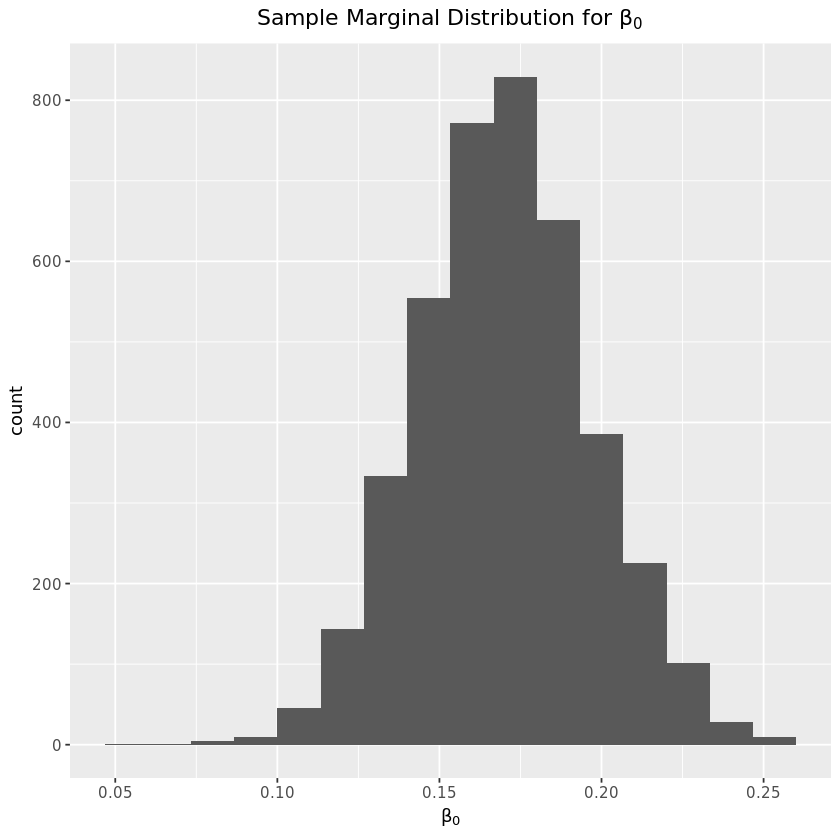

In [6]:
pdf('p3_beta_0.pdf', width=4, height=3)
p <- plot.histogram(inla.model.default.posterior.samples$intercept, quote(beta[0]))
p
dev.off()
p

png 
  2

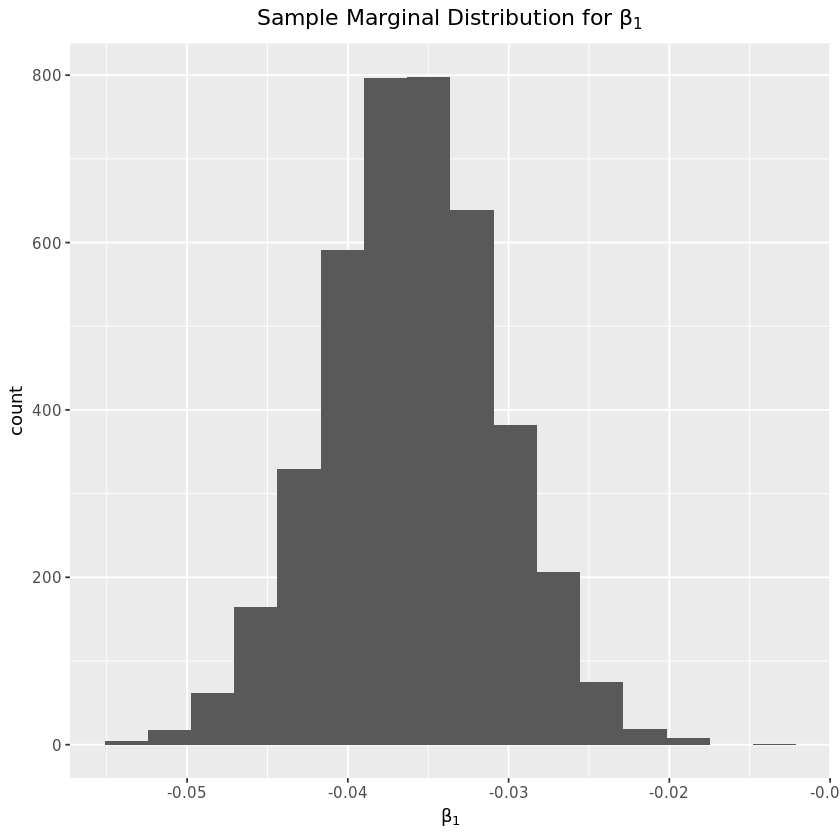

In [7]:
pdf('p3_beta_1.pdf', width=4, height=3)
p <- plot.histogram(inla.model.default.posterior.samples$radon, quote(beta[1]))
p
dev.off()
p

png 
  2

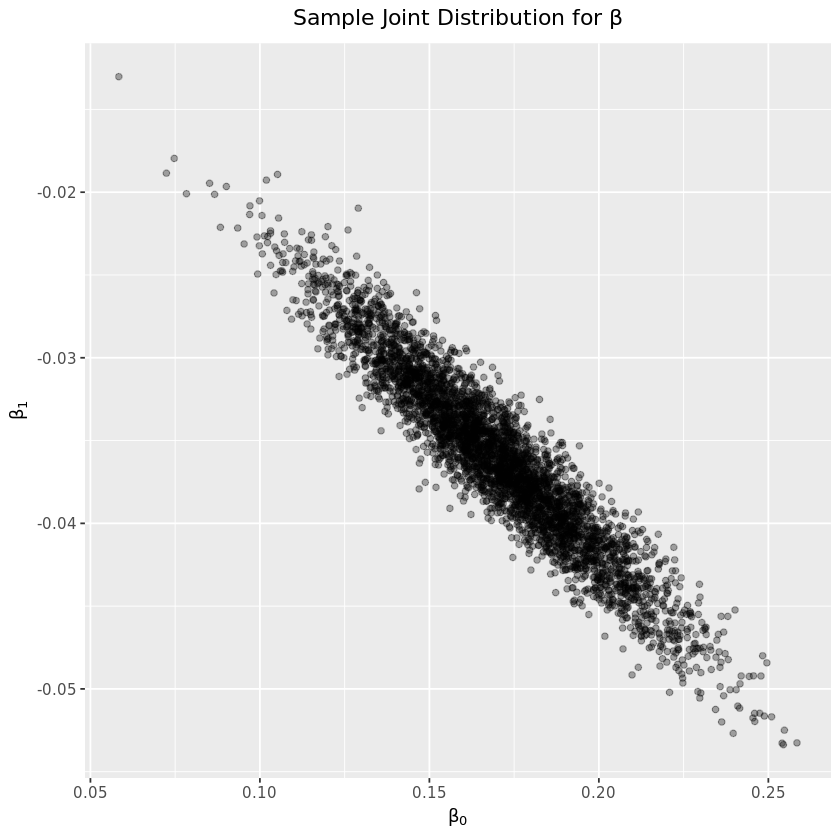

In [8]:
pdf('p3_beta_joint.pdf', width=4, height=3)
p <- ggplot(data=inla.model.default.posterior.samples, aes(intercept, radon)) +
  geom_point(alpha=1/3) +
  ggtitle(substitute('Sample Joint Distribution for '*beta)) +
  xlab(expression(beta[0])) +
  ylab(expression(beta[1]))
p
dev.off()
p

# Reparameterized Model

In [9]:
inla.model.reparameterized <- INLA::inla(
    observed ~ 1 + I(radon - mean(radon)), family='poisson', E=expected,
    data=lung.cancer.radon.data,
    control.fixed=list(
        mean.intercept=0,
        prec.intercept=1/0.21^2,
        mean=list(`I(radon - mean(radon))`=-0.02),
        prec=list(`I(radon - mean(radon))`=1/0.1^2)
    ),
    control.compute=list(config=TRUE),
    verbose=TRUE)
summary(inla.model.reparameterized)


Call:
c("INLA::inla(formula = observed ~ 1 + I(radon - mean(radon)), family = \"poisson\", ",  "    data = lung.cancer.radon.data, E = expected, verbose = TRUE, ",  "    control.compute = list(config = TRUE), control.fixed = list(mean.intercept = 0, ",  "        prec.intercept = 1/0.21^2, mean = list(`I(radon - mean(radon))` = -0.02), ",  "        prec = list(`I(radon - mean(radon))` = 1/0.1^2)))")

Time used:
 Pre-processing    Running inla Post-processing           Total 
         0.1302          0.0764          0.0138          0.2205 

Fixed effects:
                          mean     sd 0.025quant 0.5quant 0.975quant    mode
(Intercept)            -0.0208 0.0092    -0.0390  -0.0208    -0.0028 -0.0208
I(radon - mean(radon)) -0.0361 0.0054    -0.0467  -0.0361    -0.0255 -0.0360
                       kld
(Intercept)              0
I(radon - mean(radon))   0

The model has no random effects

The model has no hyperparameters

Expected number of effective parameters(std dev): 2.071(0.0

In [10]:
set.seed(2018)
inla.model.reparameterized.posterior.samples <- sample.inla(
    inla.model.reparameterized, 4096, c('(Intercept)', 'I(radon - mean(radon))'))
setnames(inla.model.reparameterized.posterior.samples, c('intercept', 'radon'))
inla.model.reparameterized.posterior.samples

intercept,radon
-0.023753616,-0.04013803
-0.013114461,-0.03418852
-0.031963324,-0.04021328
-0.010539327,-0.02891689
-0.028920653,-0.03717957
-0.022988737,-0.03721334
-0.022917927,-0.03740009
0.008750076,-0.02246524
-0.022170309,-0.03732143
-0.013318827,-0.02747977


png 
  2

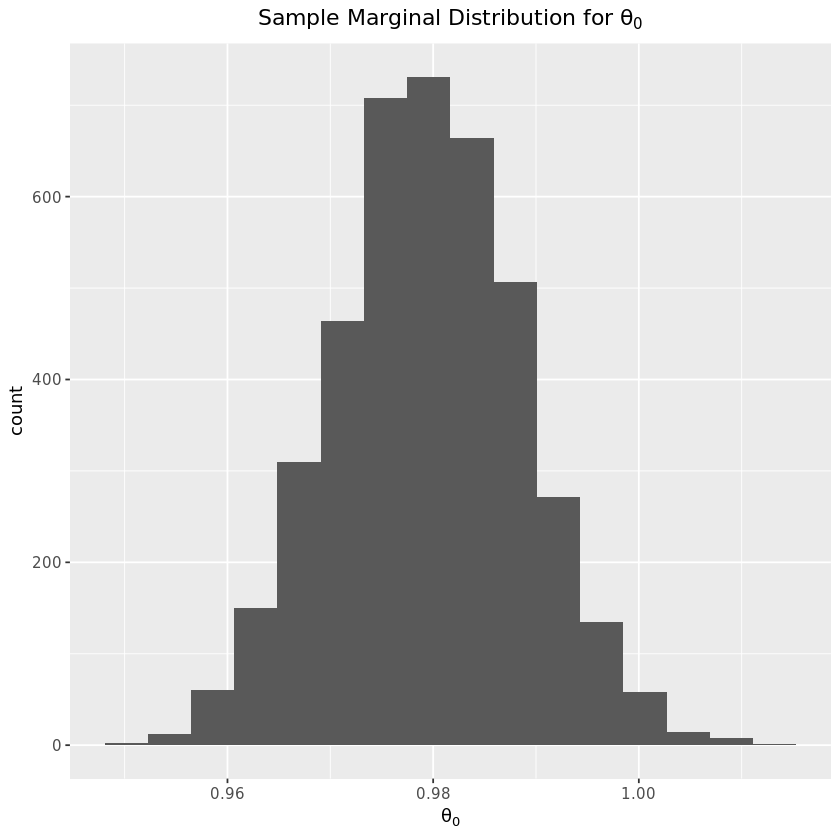

In [11]:
pdf('p3_theta_0.pdf', width=4, height=3)
p <- plot.histogram(exp(inla.model.reparameterized.posterior.samples$intercept), quote(theta[0]))
p
dev.off()
p

png 
  2

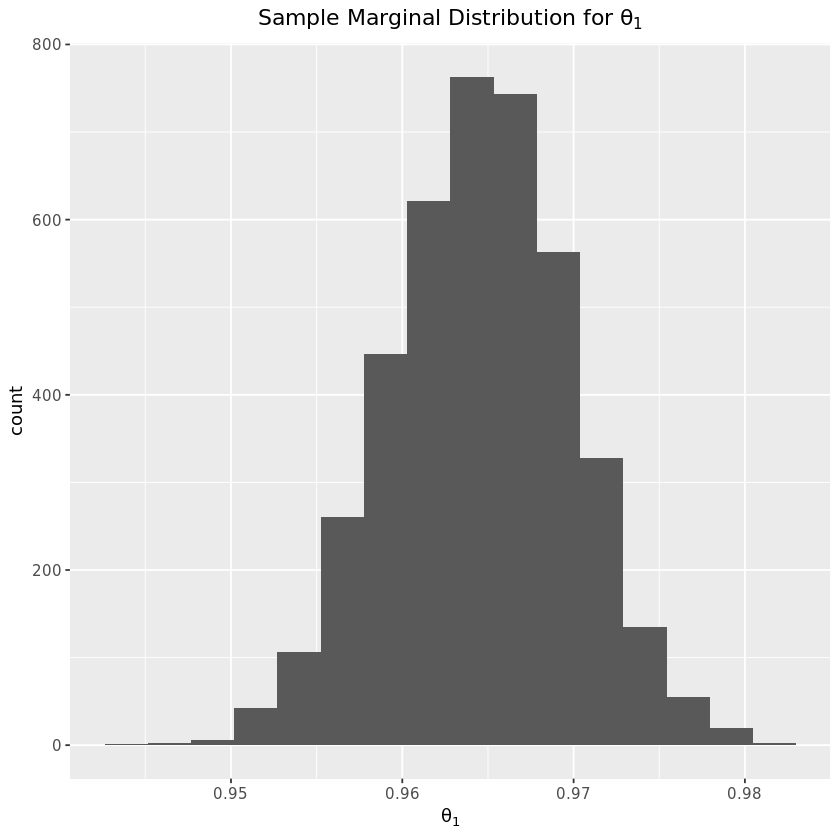

In [12]:
pdf('p3_theta_1.pdf', width=4, height=3)
p <- plot.histogram(exp(inla.model.reparameterized.posterior.samples$radon), quote(theta[1]))
p
dev.off()
p

png 
  2

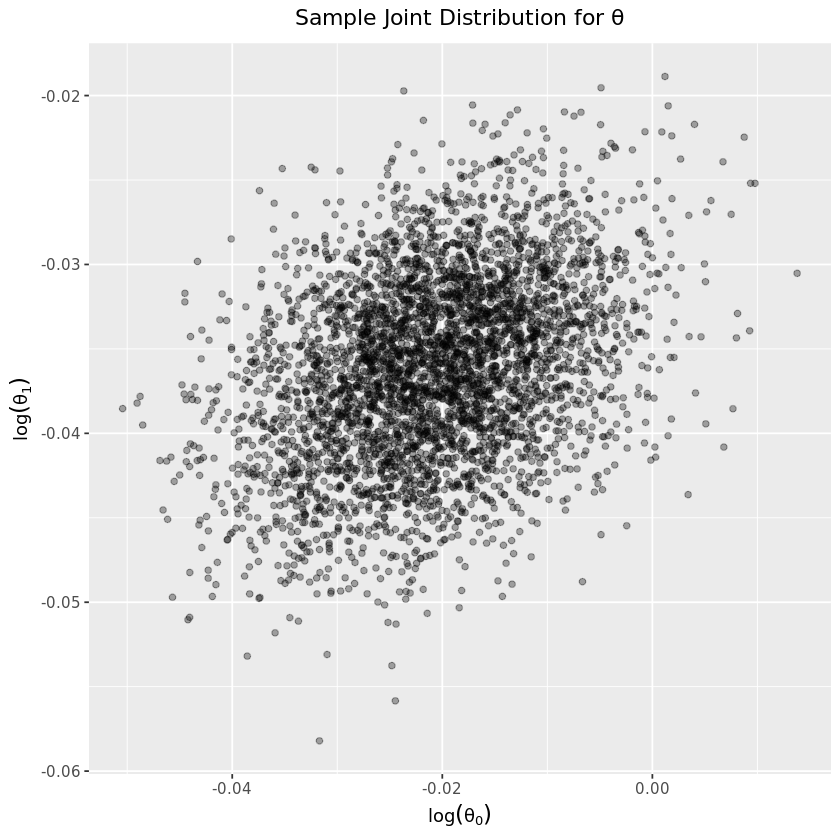

In [13]:
pdf('p3_theta_joint.pdf', width=4, height=3)
p <- ggplot(data=inla.model.reparameterized.posterior.samples, aes(intercept, radon)) +
  geom_point(alpha=1/3) +
  ggtitle(substitute('Sample Joint Distribution for '*theta)) +
  xlab(expression(log(theta[0]))) +
  ylab(expression(log(theta[1])))
p
dev.off()
p

## Tables

In [14]:
library(xtable)

#INLA::inla.qmarginal(p=0.975, inla.model.reparameterized$marginals.fixed$`I(radon - mean(radon))`)

summarize.fixed.effect <- function(inla.model, effect.name, transform=identity) {
    effect <- inla.model$marginals.fixed[[effect.name]]    
    m <- INLA::inla.emarginal(function(x) { transform(x) }, effect)
    v <- INLA::inla.emarginal(function(x) { (transform(x) - m)*(transform(x) - m) }, effect)
    c(`Posterior mean`=m,
      `Posterior standard error`=sqrt(v),
      `2.5% quantile`=transform(INLA::inla.qmarginal(p=0.025, effect)),
      `50% quantile`=transform(INLA::inla.qmarginal(p=0.5, effect)),
      `97.5% quantile`=transform(INLA::inla.qmarginal(p=0.975, effect)))
}

In [15]:
model.summary <- data.frame(
    `$\\beta_0$`=summarize.fixed.effect(inla.model.default, '(Intercept)'),
    `$\\beta_1$`=summarize.fixed.effect(inla.model.default, 'radon'), check.names=FALSE)
model.summary

,$\beta_0$,$\beta_1$
Posterior mean,0.1702240,-0.036130409
Posterior standard error,0.0268365,0.005402154
2.5% quantile,0.1176078,-0.046771610
50% quantile,0.1701280,-0.036132453
97.5% quantile,0.2227819,-0.025599931


In [16]:
print(xtable(model.summary, type='latex', booktabs=TRUE))

% latex table generated in R 3.5.1 by xtable 1.8-3 package
% Fri Nov  2 23:36:27 2018
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & \$$\backslash$beta\_0\$ & \$$\backslash$beta\_1\$ \\ 
  \hline
Posterior mean & 0.17 & -0.04 \\ 
  Posterior standard error & 0.03 & 0.01 \\ 
  2.5\% quantile & 0.12 & -0.05 \\ 
  50\% quantile & 0.17 & -0.04 \\ 
  97.5\% quantile & 0.22 & -0.03 \\ 
   \hline
\end{tabular}
\end{table}


In [17]:
model.summary <- data.frame(
    `$\\theta_0$`=summarize.fixed.effect(
        inla.model.reparameterized, '(Intercept)', exp),
    `$\\theta_1$`=summarize.fixed.effect(
        inla.model.reparameterized, 'I(radon - mean(radon))', exp),
    check.names=FALSE)
model.summary

,$\theta_0$,$\theta_1$
Posterior mean,0.979415596,0.964581545
Posterior standard error,0.009010937,0.005202032
2.5% quantile,0.961797851,0.954374782
50% quantile,0.979365969,0.964565469
97.5% quantile,0.997111419,0.974761813


In [18]:
print(xtable(model.summary, type='latex', booktabs=TRUE))

% latex table generated in R 3.5.1 by xtable 1.8-3 package
% Fri Nov  2 23:36:27 2018
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & \$$\backslash$theta\_0\$ & \$$\backslash$theta\_1\$ \\ 
  \hline
Posterior mean & 0.98 & 0.96 \\ 
  Posterior standard error & 0.01 & 0.01 \\ 
  2.5\% quantile & 0.96 & 0.95 \\ 
  50\% quantile & 0.98 & 0.96 \\ 
  97.5\% quantile & 1.00 & 0.97 \\ 
   \hline
\end{tabular}
\end{table}
